In [1]:
"""Use GMRES and augmented least squares to find optimal Tikhonov regularisation"""

'Use GMRES and augmented least squares to find optimal Tikhonov regularisation'

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

from deblurring.blurring import blur_and_noise
from solvers.least_square import GMRESSolver, LSQRSolver
from common.operators import derivative_operator, identity_operator
from evaluation.tuning import StandardTuner

Estimated noise variance 0.0003977830768104477 vs. actual 0.0004


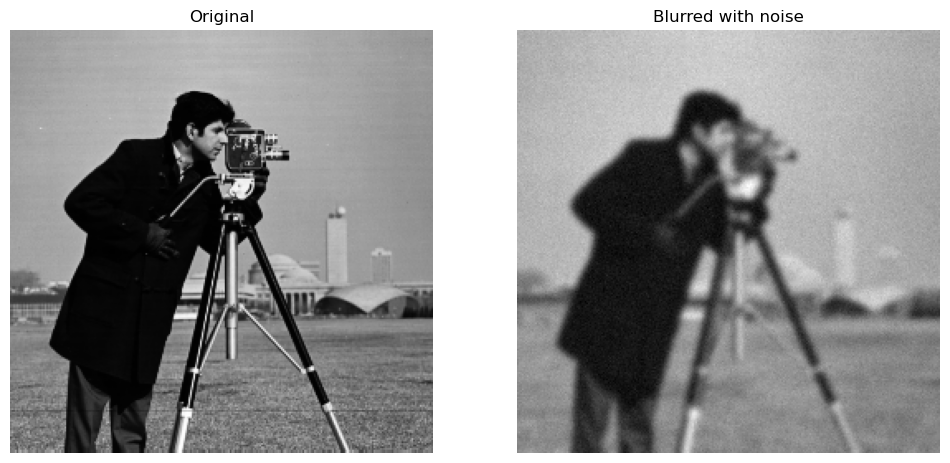

In [3]:
"""Read image and blur with added noise"""

f = plt.imread("../../data/Cameraman256.png")
f = (f - f.min()) / (f.max() - f.min())

theta = 0.02
sigma = 2.0
kernel = partial(gaussian_filter, sigma=sigma)
g = blur_and_noise(f, kernel, theta)
noise_variance = np.var(blur_and_noise(np.zeros_like(g), kernel, theta))
print(f"Estimated noise variance {noise_variance} vs. actual {np.square(theta)}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(f, cmap="gray")
plt.axis("off")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(g, cmap="gray")
plt.axis("off")
plt.title("Blurred with noise")
plt.show()

In [4]:
"""Set up parameters, regularisation operators and tuners"""

alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

gmres_tuner = StandardTuner(
    solver=GMRESSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)

lsqr_tuner = StandardTuner(
    solver=LSQRSolver,
    g=g,
    A=kernel,
    noise_variance=noise_variance,
    f=f,
)

[INFO] 2025-02-25 21:02:30 | Alpha 1e-08: discrepancy -0.00010634127626945363 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:03:10 | Alpha 1e-07: discrepancy -0.0001060579262993372 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:03:48 | Alpha 1e-06: discrepancy -0.00010383157980915433 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:06 | Alpha 1e-05: discrepancy -9.51725722238205e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:11 | Alpha 0.0001: discrepancy -8.022052107434094e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:12 | Alpha 0.001: discrepancy -6.25313504976763e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:12 | Alpha 0.01: discrepancy -1.2685273313423507e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:12 | Alpha 0.1: discrepancy 0.002276894782639185 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:12 | Alpha 1.0: discrepancy

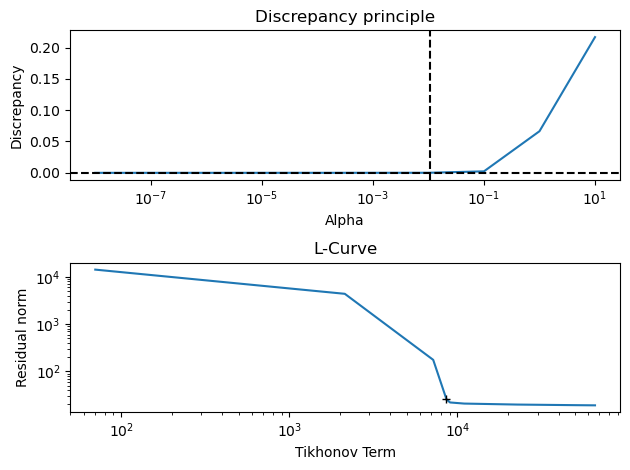

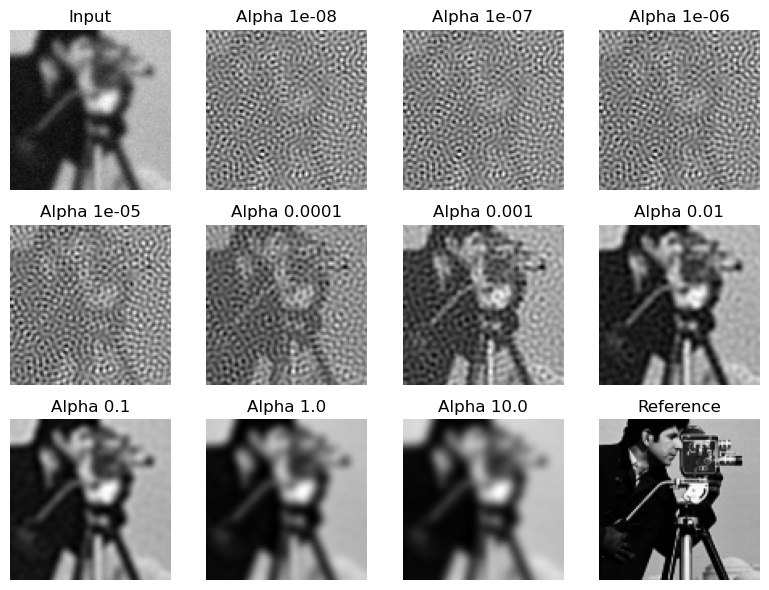

Optimal alpha: 0.010498639300792261
DP: -9.254220607747554e-06, MSE: 0.004412233577932923


In [5]:
"""Find optimal alpha using GMRES and TK0"""

gmres_tuner.parameter_sweep(alphas=alphas, L=identity_operator, save_imgs=True)
gmres_tuner.display_metrics()
gmres_tuner.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {gmres_tuner.optimal_alpha}")
print(f"DP: {gmres_tuner.optimal_metrics['discrepancy']}, MSE: {gmres_tuner.optimal_metrics['MSE']}")
gmres_tk0_f_hat = gmres_tuner._optimal_f_hat

[INFO] 2025-02-25 21:04:15 | Alpha 1e-08: discrepancy -8.310710826533795e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:16 | Alpha 1e-07: discrepancy -8.310693830709825e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:17 | Alpha 1e-06: discrepancy -8.310413525307314e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:18 | Alpha 1e-05: discrepancy -8.299972768675216e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:19 | Alpha 0.0001: discrepancy -7.944305659039747e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:19 | Alpha 0.001: discrepancy -6.291781372599756e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:20 | Alpha 0.01: discrepancy -1.2746773065161043e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:20 | Alpha 0.1: discrepancy 0.002276930929741521 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:04:20 | Alpha 1.0: discrepancy

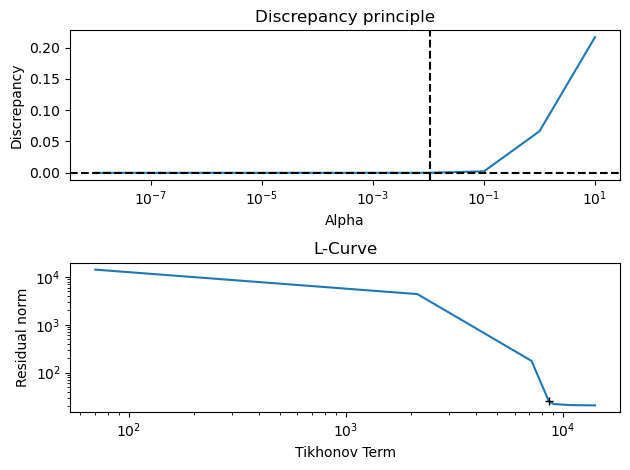

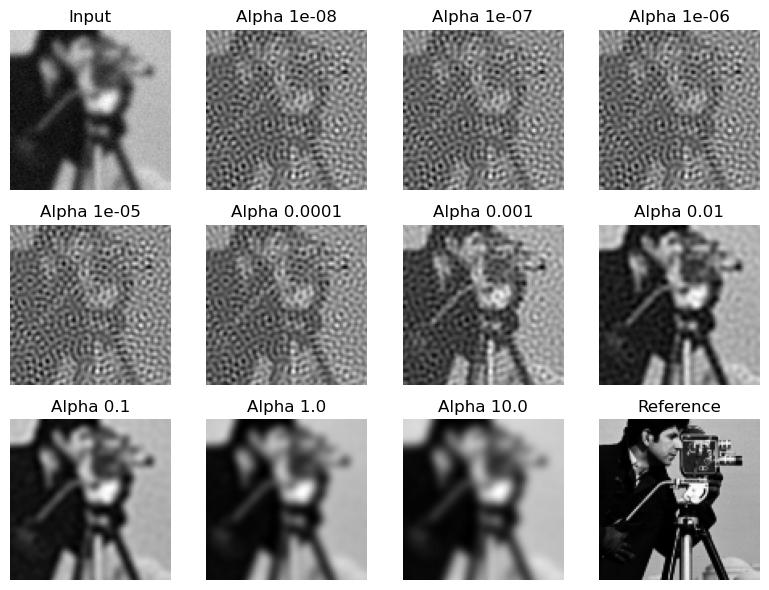

Optimal alpha: 0.010501035396579286
DP: -9.301412169216154e-06, MSE: 0.004412913349145579


In [6]:
"""Find optimal alpha using LSQR and TK0"""

lsqr_tuner.parameter_sweep(alphas=alphas, L=identity_operator, save_imgs=True)
lsqr_tuner.display_metrics()
lsqr_tuner.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_tuner.optimal_alpha}")
print(f"DP: {lsqr_tuner.optimal_metrics['discrepancy']}, MSE: {lsqr_tuner.optimal_metrics['MSE']}")
lsqr_tk0_f_hat = lsqr_tuner._optimal_f_hat

[INFO] 2025-02-25 21:05:07 | Alpha 1e-08: discrepancy -0.00010628643415583442 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:05:45 | Alpha 1e-07: discrepancy -0.00010557538744557189 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:07 | Alpha 1e-06: discrepancy -0.00010121880789882448 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:17 | Alpha 1e-05: discrepancy -9.011200905121821e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:20 | Alpha 0.0001: discrepancy -7.507484100125128e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:21 | Alpha 0.001: discrepancy -5.8851698341892515e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:22 | Alpha 0.01: discrepancy -3.867018731194431e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:22 | Alpha 0.1: discrepancy 1.918407310684539e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:22 | Alpha 1.0: discrep

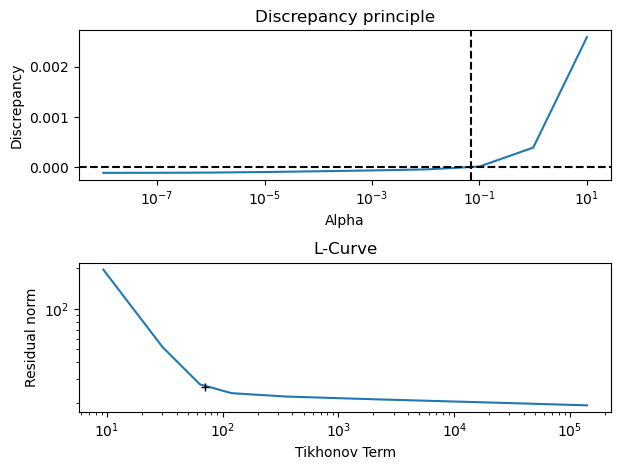

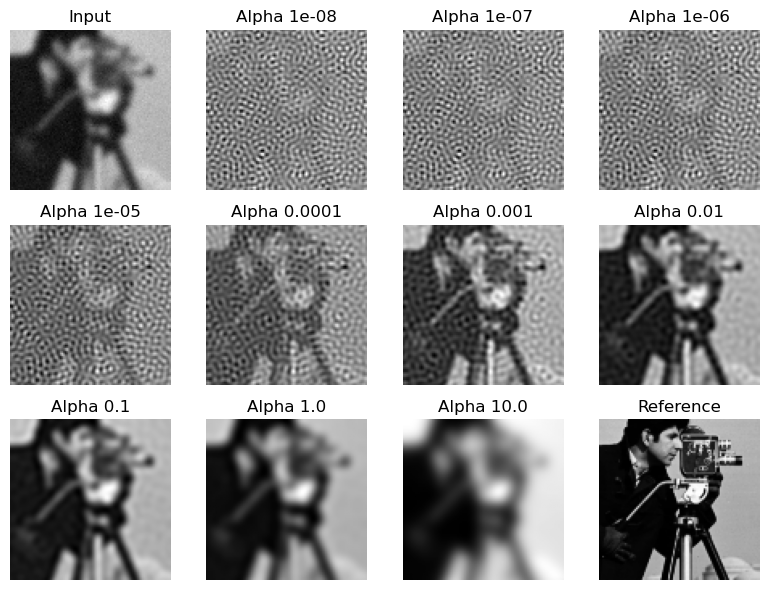

Optimal alpha: 0.07015662170567931
DP: 2.943725672166389e-06, MSE: 0.004757437125037333


In [7]:
"""Find optimal alpha using GMRES and TK1"""
gmres_tuner.parameter_sweep(alphas=alphas, L=derivative_operator, save_imgs=True)
gmres_tuner.display_metrics()
gmres_tuner.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {gmres_tuner.optimal_alpha}")
print(f"DP: {gmres_tuner.optimal_metrics['discrepancy']}, MSE: {gmres_tuner.optimal_metrics['MSE']}")
gmres_tk1_f_hat = gmres_tuner._optimal_f_hat

[INFO] 2025-02-25 21:06:25 | Alpha 1e-08: discrepancy -8.310697662531431e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:26 | Alpha 1e-07: discrepancy -8.310559642436864e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:27 | Alpha 1e-06: discrepancy -8.308825234549182e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:28 | Alpha 1e-05: discrepancy -8.265312311342605e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:29 | Alpha 0.0001: discrepancy -7.552989906642001e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:30 | Alpha 0.001: discrepancy -5.915240667387305e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:30 | Alpha 0.01: discrepancy -3.874032528144777e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:30 | Alpha 0.1: discrepancy 1.917033448805178e-05 | evaluation.eval_metrics-log_metrics:209
[INFO] 2025-02-25 21:06:30 | Alpha 1.0: discrepancy

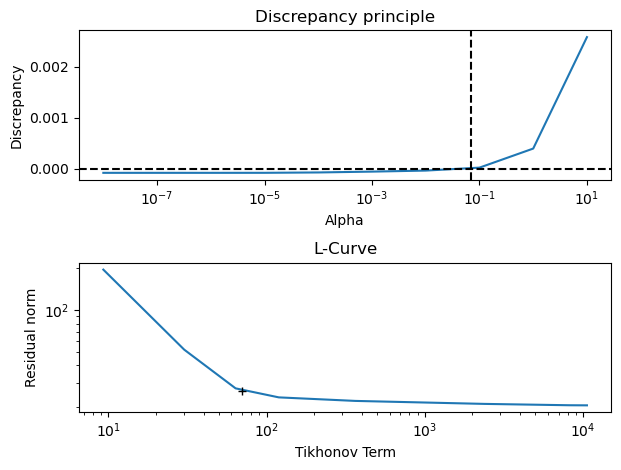

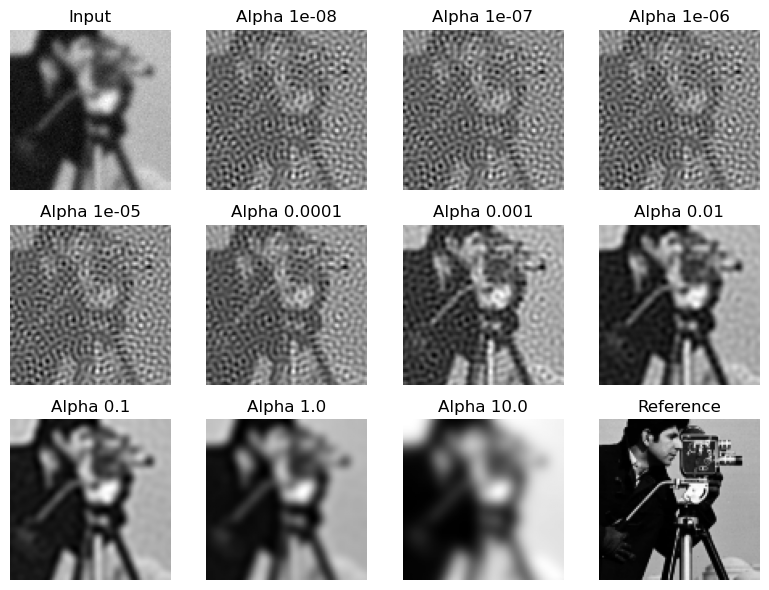

Optimal alpha: 0.07020703768888231
DP: 2.9607045701960624e-06, MSE: 0.004757349993571292


In [8]:
"""Find optimal alpha using LSQR and TK1"""
lsqr_tuner.parameter_sweep(alphas=alphas, L=derivative_operator, save_imgs=True)
lsqr_tuner.display_metrics()
lsqr_tuner.display_sample(slice(50, 150), slice(80, 180))
print(f"Optimal alpha: {lsqr_tuner.optimal_alpha}")
print(f"DP: {lsqr_tuner.optimal_metrics['discrepancy']}, MSE: {lsqr_tuner.optimal_metrics['MSE']}")
lsqr_tk1_f_hat = lsqr_tuner._optimal_f_hat

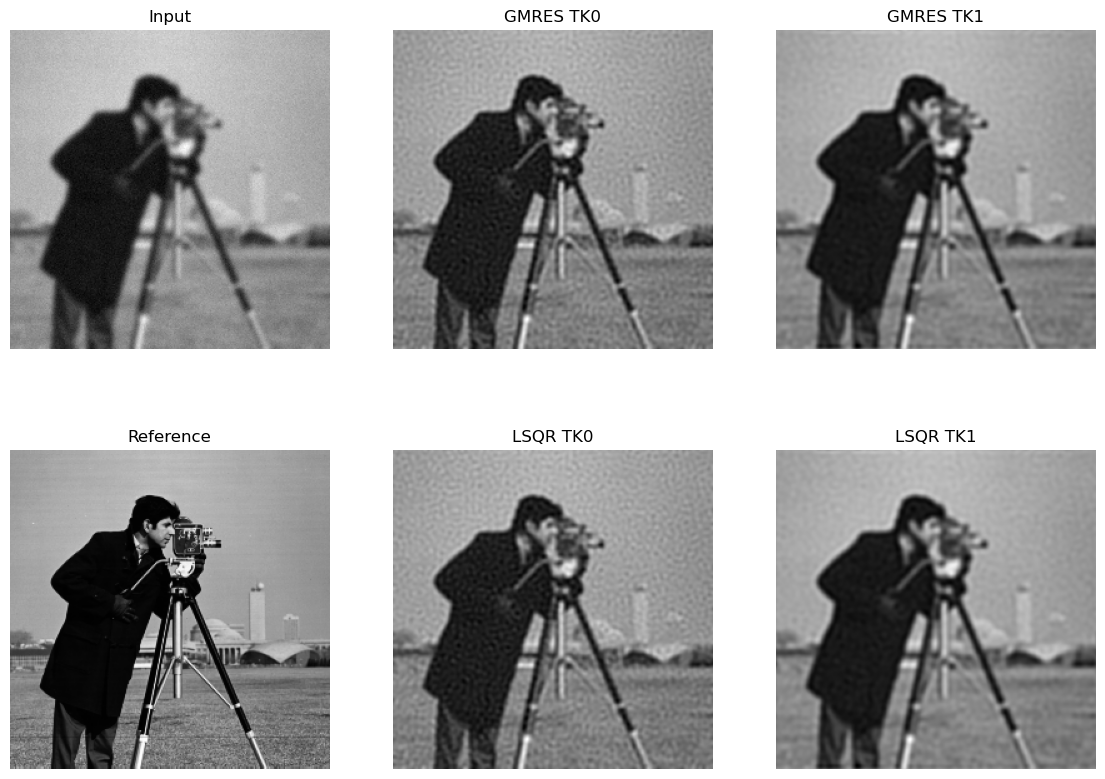

In [9]:
"""Compare different techniques"""

_, axs = plt.subplots(2, 3, figsize=(14, 10))
axs[0, 0].imshow(g, cmap="gray")
axs[0, 0].set_title("Input")
axs[0, 0].axis("off")
axs[0, 1].imshow(gmres_tk0_f_hat, cmap="gray")
axs[0, 1].set_title("GMRES TK0")
axs[0, 1].axis("off")
axs[0, 2].imshow(gmres_tk1_f_hat, cmap="gray")
axs[0, 2].set_title("GMRES TK1")
axs[0, 2].axis("off")
axs[1, 0].imshow(f, cmap="gray")
axs[1, 0].set_title("Reference")
axs[1, 0].axis("off")
axs[1, 1].imshow(lsqr_tk0_f_hat, cmap="gray")
axs[1, 1].set_title("LSQR TK0")
axs[1, 1].axis("off")
axs[1, 2].imshow(lsqr_tk1_f_hat, cmap="gray")
axs[1, 2].set_title("LSQR TK1")
axs[1, 2].axis("off")
plt.show()